Wine review
===========

This notebook contains all the code for the wine review problem.
As the dataset have a "points" field that gives notation of the wine, we will try to perform a regression task to predict the score of a wine.

In [1]:
# data managment
import pandas as pd
import numpy as np
from lib.RegressorManager import *
# preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lib.transformer.auto_transforms import AutoTransform
from lib.transformer.basic_transforms import OneHotEncodeTransform
# plotting
from matplotlib import pyplot as plt
import seaborn as sns
# learning
from sklearn.tree import tree
from sklearn.model_selection import cross_val_score


sns.set(color_codes=True)

In [2]:
# load our train and test datasets
initial_df = pd.read_csv("datasets/wine_reviews/winemag-data-130k-v2.csv")

In [3]:
regressor_manager = RegressorManager()

data preparation
----------------

first we need to clean the dataset, for this we will
 - select relevant columns
 - drop row containing na value (we can afford this because the ratio *number of row / input space dimension* is still good )
 - remove duplicate rows

In [4]:
clean_df = initial_df.copy()
include = ['country', 'designation', 'points', 'price', 'province', 'variety']
categorical = ['country', 'designation', 'province', 'variety']
clean_df = clean_df[include]
clean_df = clean_df.dropna(axis=0, how='any')
clean_df = clean_df.drop_duplicates(subset=include)
print("there are " + str(len(clean_df)) + " entries left after cleaning")
clean_df.head()

there are 75344 entries left after cleaning


,country,designation,points,price,province,variety
1,Portugal,Avidagos,87,15.0,Douro,Portuguese Red
3,US,Reserve Late Harvest,87,13.0,Michigan,Riesling
4,US,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Pinot Noir
5,Spain,Ars In Vitro,87,15.0,Northern Spain,Tempranillo-Merlot
6,Italy,Belsito,87,16.0,Sicily & Sardinia,Frappato


now we have clean data, we can grab some infos about the datatset

In [5]:
print("mean:"+str(np.mean(clean_df.query('price>0')['price'])))
print("median:" + str(np.median(clean_df.query('price>0')['price'])))
print("variance:" + str(np.var(clean_df.query('price>0')['price'])))
print("min:" + str(np.min(clean_df.query('price>0')['price'])))
print("max:" + str(np.max(clean_df.query('price>0')['price'])))

mean:37.93065141218943
median:29.0
variance:1399.0479753349093
min:4.0
max:2013.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 75344 entries, 1 to 129970
Data columns (total 6 columns):
country        75344 non-null object
designation    75344 non-null object
points         75344 non-null int64
price          75344 non-null float64
province       75344 non-null object
variety        75344 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 4.0+ MB
None


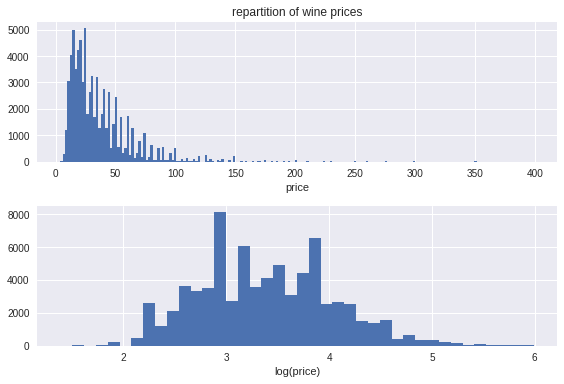

In [6]:
print(clean_df.info())
fig, ax = plt.subplots(2)
ax[0].hist(clean_df.query('(price>0)and(price<400)')['price'], 200)
ax[0].set_xlabel('price')
ax[0].set_title("repartition of wine prices")
ax[1].hist(np.log(clean_df.query('(price>0)and(price<400)')['price']), 40)
ax[1].set_xlabel('log(price)')
fig.tight_layout()
plt.show()

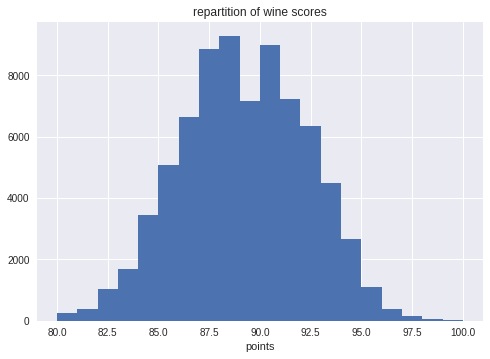

In [7]:
fig, ax = plt.subplots()
ax.hist(clean_df['points'], 20)
ax.set_xlabel('points')
ax.set_title("repartition of wine scores")
plt.show()

In [8]:
corr = clean_df[['price', 'points']].corr()
print(corr)

           price    points
price   1.000000  0.455702
points  0.455702  1.000000


Now we can split the dataset:

In [9]:
X = clean_df[['country', 'designation', 'price', 'province', 'variety']]
y = clean_df['points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

then we can prepare the dataset for use with scikit learn

first we need to reduce the number of categorical features, we need additionnal info to choose proper number of features wanted

In [10]:
print(str(len(np.where(X_train['designation'].value_counts() > 20)[0])) + " categories for designation have more than 20 elements")
print(str(len(np.where(X_train['country'].value_counts() > 20)[0])) + " categories for country have more than 20 elements")
print(str(len(np.where(X_train['province'].value_counts() > 20)[0])) + " categories for province have more than 20 elements")
print(str(len(np.where(X_train['variety'].value_counts() > 20)[0])) + " categories for variety have more than 20 elements")

90 categories for designation have more than 20 elements


28 categories for country have more than 20 elements
114 categories for province have more than 20 elements
129 categories for variety have more than 20 elements


the auto transform is used here to reduce the number of categories, and to normalize the numerical features.
The get_dummies act as an onehot encoder.

In [11]:
pipeline = Pipeline(
    [
        ('auto_transform', AutoTransform(include=include,
                                         force_categorical=categorical,
                                         max_cat_percent=75, min_cat_percent=0.0005,
                                         nan_threshold=0.5)),
        ('one_hot', OneHotEncodeTransform(excluded=['price']))
    ]
)


In [12]:
pipeline.fit(X_train, y_train)

/home/thibaut/Documents/cours/GT/spring 2018/courses/ML/lib/transformer/auto_transforms.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].apply(lambda x: np.nan if isinstance(x, str) and len(x)==0 else x)


Pipeline(steps=[('auto_transform', AutoTransform(bool_map={'true': 1, 'false': 0, '1': 1, '0': 0, 'yes': 1, 'no': 0, '1.0': 1, '0.0': 0},
       cat_missing_val='UKN', create_date_differences=False,
       custom_date_formats=None, date_cols=[],
       date_transforms=[True, True, True, True], drop_cols=[],
...5, min_max_limit=False, nan_threshold=0.5)), ('one_hot', OneHotEncodeTransform(excluded=['price']))])

In [13]:
X_test_prepared = pipeline.transform(X_test)
to_drop = X_test_prepared.loc[:, X_test_prepared.isnull().any()].columns
X_test_prepared = X_test_prepared.drop(to_drop, axis=1)
X_train_prepared = pipeline.transform(X_train)
to_drop = X_train_prepared.loc[:, X_train_prepared.isnull().any()].columns
X_train_prepared = X_train_prepared.drop(to_drop, axis=1)

Trees
=====

In [14]:

my_tree = tree.DecisionTreeRegressor()
my_tree.fit(X_train_prepared, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [15]:
print(my_tree.score(X_train_prepared, y_train))
print(my_tree.score(X_test_prepared, y_test))

0.00028519840678553588

In [16]:
np.var(cross_val_score(my_tree, X_train_prepared, y_train, cv=10))

0.00028519840678553588

In [17]:
mean_absolute_error(y_test, my_tree.predict(X_test_prepared))

2.076175338380883

In [18]:
depths = range(1, 20)

In [20]:
for i in depths:
    res = regressor_manager.add_regressor(
        "tree_depth"+str(i),
        tree.DecisionTreeRegressor(max_depth=i),
        X_train_prepared, y_train, X_test_prepared, y_test)

In [22]:
test_accuracy = []
train_accuracy = []
test_time = []
train_time = []

for i in depths:
    classifier = regressor_manager.dict["tree_depth"+str(i)]
    predicted = classifier['predicted_data']
    test_accuracy.append(mean_absolute_error(y_test, predicted))
    train_accuracy.append(mean_absolute_error(y_train, classifier['instance'].predict(X_train_prepared)))
    train_time.append(classifier['training_duration'])
    test_time.append(classifier['prediction_duration'])
    #classifier_size.append(utils.get_size(classifier['instance']))

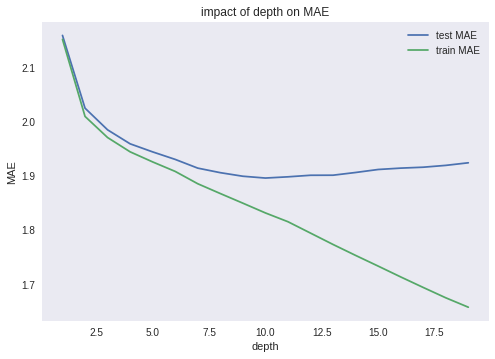

In [24]:
fig, ax = plt.subplots()
ax.plot(depths, test_accuracy, label='test MAE')
ax.plot(depths, train_accuracy, label='train MAE')
ax.set(xlabel='depth', ylabel='MAE', title='impact of depth on MAE')
ax.grid()

plt.legend()
fig.savefig("figs/wine_trees_accuracy.png")
plt.show()

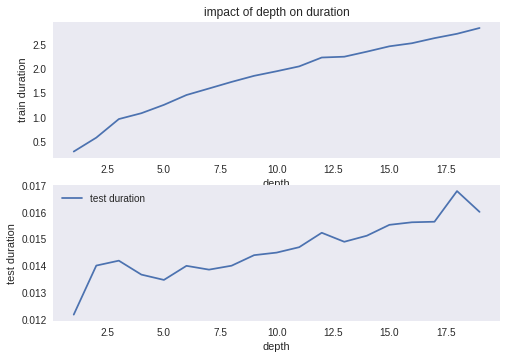

In [26]:
fig, ax = plt.subplots(2)

ax[0].plot(depths, train_time, label='train duration')
ax[0].set(xlabel='depth', ylabel='train duration', title='impact of depth on duration')
ax[0].grid()

ax[1].plot(depths, test_time, label='test duration')
ax[1].set(xlabel='depth', ylabel='test duration')
ax[1].grid()

plt.legend()
fig.savefig("figs/wine_trees_duration.png")
plt.show()

Neural networks
---------------

In [29]:
from sklearn.neural_network import MLPRegressor

N = 5
values_to_try = []
for x, y in np.ndindex((N, N)):
    values_to_try.append(((x + 1) * 5, (y + 1) * 5))


def train_value(value):
    max_iter = 200000
    (width, depth) = value
    key_name = "neural_" + str(width) + "x" + str(depth) + "_iter_"+str(max_iter)
    return regressor_manager.add_regressor(
        key_name,
        MLPRegressor(solver='adam', alpha=1e-5, max_iter=max_iter, hidden_layer_sizes=value, random_state=1),
        X_train_prepared, y_train, X_test_prepared, y_test)

for val in values_to_try:
    results = train_value(val)